In [38]:
import os
import nltk
import csv
from matplotlib.pyplot import cm
import numpy as np
from nltk.corpus import stopwords
import math

import matplotlib.pyplot as plt


from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from community import community_louvain
from fa2 import ForceAtlas2

In [39]:
characters = []

# Get characters and communities, according to fandom graph
with open("communities_from_fandom.csv", "r", encoding="utf8") as sent_file:
    csv = csv.reader(sent_file, delimiter=",")
    for row in csv:
        name = row[0]
        community = row[1]
        characters.append((name, community))

In [40]:
import csv
# Create an empty list to store tuples of words and their 
# average happiness score
sent_list = []

# Read in the .tsv file
with open("LabMT1.0.tsv", "r", encoding="utf8") as sent_file:
    tsv_reader = csv.DictReader(sent_file, delimiter="\t")
    # For each sentiment in the file, save the word and average happiness in a tuple
    # and add it to the list
    for sent in tsv_reader:
        word = sent["word"]
        average = sent["happiness_average"]
        sent_list.append((word, average))

## Calculating sentiment for characters by chapter

In [41]:
# Defining function to calculate sentiment for a list of tokens
# Function for calculating the sentiment of a file from the frequency distribution for that file
def sentiment(tokens):
    # Total sentiment score of file
    sent_sum = 0.0
    # Total number of occurences of words
    occ_sum = 0
    
    # For each token and associated number of occurences
    for token, occ in tokens.items():
        # If the token is in the given list of words with rated happiness
        for word, score in sent_list:
            if token == word:
                sent_sum += (float(score) * occ)
                occ_sum += occ
    return sent_sum / occ_sum

In [46]:
# Finding sentiment from a concordance list
def con_sentiment(con_list):
    sent_sum = 0
    line_num = 0
    for item in con_list:
        # Make left and right into one list
        left = [ch.lower() for ch in item.left if ch.isalpha()]
        right = [ch.lower() for ch in item.right if ch.isalpha()]
        combined = left + right
        #combined = [w for w in (left + right) if w not in stopwords]
        # Make freqDist, just in case
        fd = nltk.FreqDist(combined)
        sent_sum += sentiment(fd)
        line_num += 1
    if line_num == 0:
        return 0 # Character had no appearences in chapter
    return sent_sum / line_num

In [44]:
stopwords = nltk.corpus.stopwords.words('english')

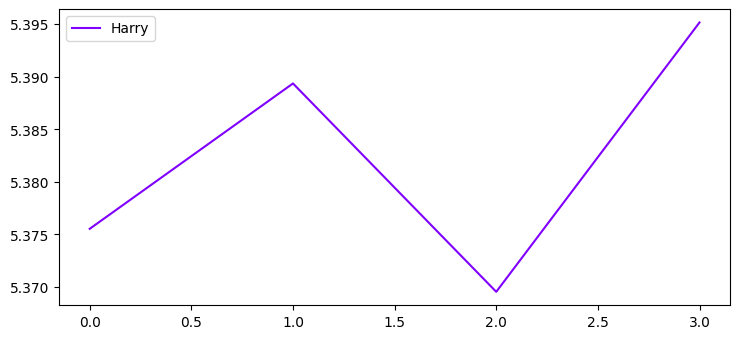

[('Harry', [5.375511877431059, 5.389341527937704, 5.369517925069885, 5.395145458790369])]


In [50]:
# Assuming we have a list of the character names as we expect they appear
# Assuming we have the chapters each book as .txt files
char_list = ["Harry"] # List of character names as they appear

# Assuming folder structure books/book_n/chapter_n.txt
chapters = ["test1.txt", "test2.txt", "test3.txt", "test4.txt"] # os.listdir(books/book_n)

# Making a data table (char_list)x(num_chapters) to hold sentiments for each char in each chap
# tuple list with tuples (character, [sent chapter1, sent chapter2, ...])
sentiment_by_character = []

for character in char_list:
    sentiments = []
    for chapter in chapters:
        f = open(chapter)
        raw = f.read()
        tokens = nltk.wordpunct_tokenize(raw)
        text = nltk.Text(tokens)
        con = text.concordance_list(character)
        sentiments.append(con_sentiment(con))
    sentiment_by_character.append((character, sentiments))

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
color = iter(cm.rainbow(np.linspace(0, 1, len(char_list))))

for name, sentiments in sentiment_by_character:
    c = next(color)
    plt.plot(sentiments, c=c, label=name)

plt.legend()
plt.show()

print(sentiment_by_character)

### Example start

In [12]:
# Reading in the test text
f = open('test1.txt')
raw = f.read()
tokens = nltk.wordpunct_tokenize(raw)
text = nltk.Text(tokens)

In [ ]:
text.dispersion_plot(["Harry", "Dudley", "Mr", "Mrs", "Dursley", "Dumbledore", "Voldemort"])

In [18]:
harry_con = text.concordance_list("Harry")
dursley_con = text.concordance_list("Dursley")
dumble_con = text.concordance_list("Dumbledore")
volde_con = text.concordance_list("Voldemort")

cons = [harry_con, dursley_con, dumble_con, volde_con]

# harry_con, type list
# harry_con[0], type ConcodanceLine
# harry_con[0].left, list of tokens appearing to the left
# harry_con[0].right, list of tokens appearing to the right

# nltk.FreqDist(harry_con[0].left)

for con in harry_con:
    print(con.left)
    print()

['The', 'Potters', ',', 'that', "'", 's', 'right', ',', 'that', "'", 's', 'what', 'I', 'heard', 'yes', ',', 'their', 'son', ',']

['an', 'unusual', 'name', '.', 'He', 'was', 'sure', 'there', 'were', 'lots', 'of', 'people', 'called', 'Potter', 'who', 'had', 'a', 'son', 'called']

['called', 'Harry', '.', 'Come', 'to', 'think', 'of', 'it', ',', 'he', 'wasn', "'", 't', 'even', 'sure', 'his', 'nephew', 'was', 'called']

['Dursley', 'stiffly', '.', '"', 'What', "'", 's', 'his', 'name', 'again', '?', 'Howard', ',', 'isn', "'", 't', 'it', '?"', '"']

["'", 's', 'not', 'all', '.', 'They', "'", 're', 'saying', 'he', 'tried', 'to', 'kill', 'the', 'Potter', "'", 's', 'son', ',']

['one', 'knows', 'why', ',', 'or', 'how', ',', 'but', 'they', "'", 're', 'saying', 'that', 'when', 'he', 'couldn', "'", 't', 'kill']

['just', 'astounding', '...', 'of', 'all', 'the', 'things', 'to', 'stop', 'him', '...', 'but', 'how', 'in', 'the', 'name', 'of', 'heaven', 'did']

['tell', 'me', 'why', 'you', "'", 're', '

In [ ]:
#sentiment(nltk.FreqDist(harry_con[0].left))
#print(harry_con[0].left)
fd = nltk.FreqDist(harry_con[0].left)
#sentiment(fd)
left = [ch.lower() for ch in harry_con[0].left if ch.isalpha()]
right = [ch.lower() for ch in harry_con[0].right if ch.isalpha()]
combined = left + right


In [ ]:
# Testing con_sentiment
for con in cons:
    print(con_sentiment(con))